### Voxel Response Matrix Processing and Visualization

This cell processes voxel-wise fMRI responses for a selected subject and ROI group. It performs the following steps:

1. **Configuration**  
   Set the `subject_id`, ROI labels (e.g., `["V1v", "V1d"]`), and a group label for the output filename (e.g., `"V1"`).

2. **Data Loading or Generation**  
   If a matching CSV file already exists, it is loaded. Otherwise, beta session NIfTI files are loaded, mean responses are computed across time, and the resulting voxel × session matrix is filtered by the selected ROIs using `prf-visualrois.nii.gz`.

3. **Saving**  
   The filtered matrix is saved as:  
   `{subject_id}_voxel_mean_response_matrix_{roi_group_label}.csv`

4. **Visualization**  
   - Clipped heatmap of raw voxel responses  
   - Z-scored heatmap (per voxel)  
   - Time series plot for 100 random voxels (one highlighted)  
   - Histogram of voxel-wise drift slopes (linear trends)  
   - Plot of mean ± std response across sessions

This allows analysis across sessions, tailored by subject and ROI.

Loaded existing voxel mean response matrix from CSV.


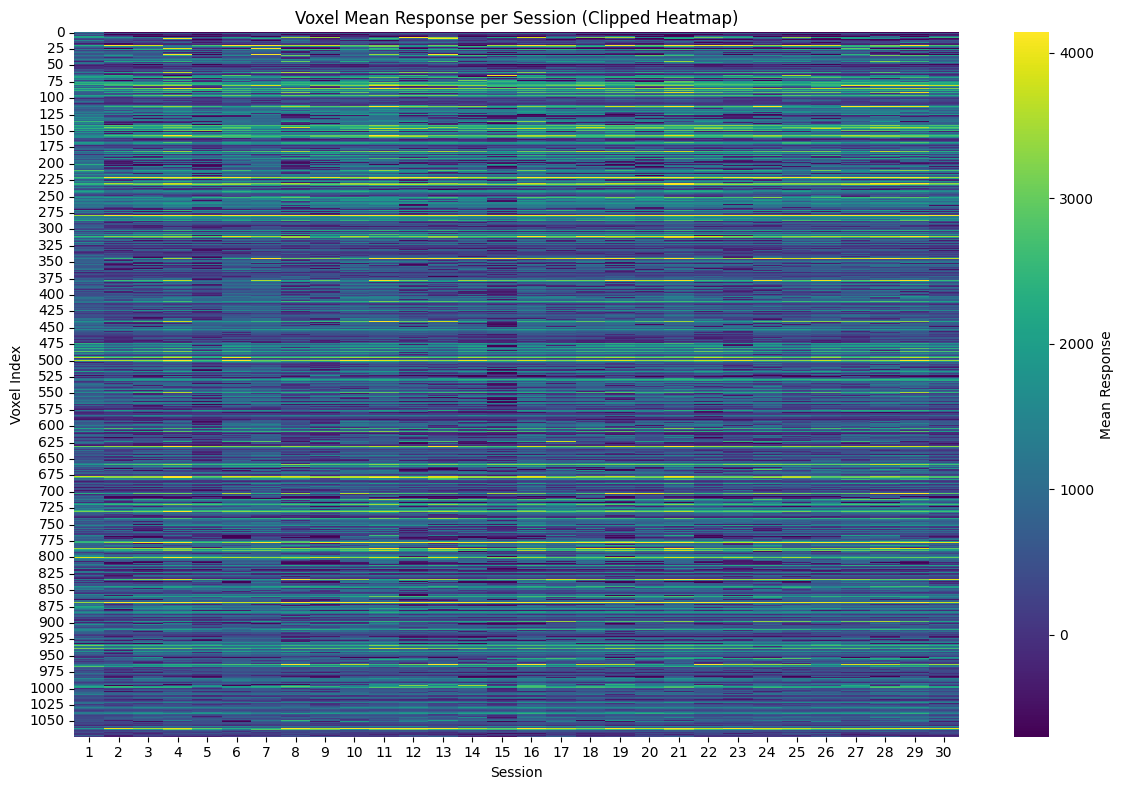

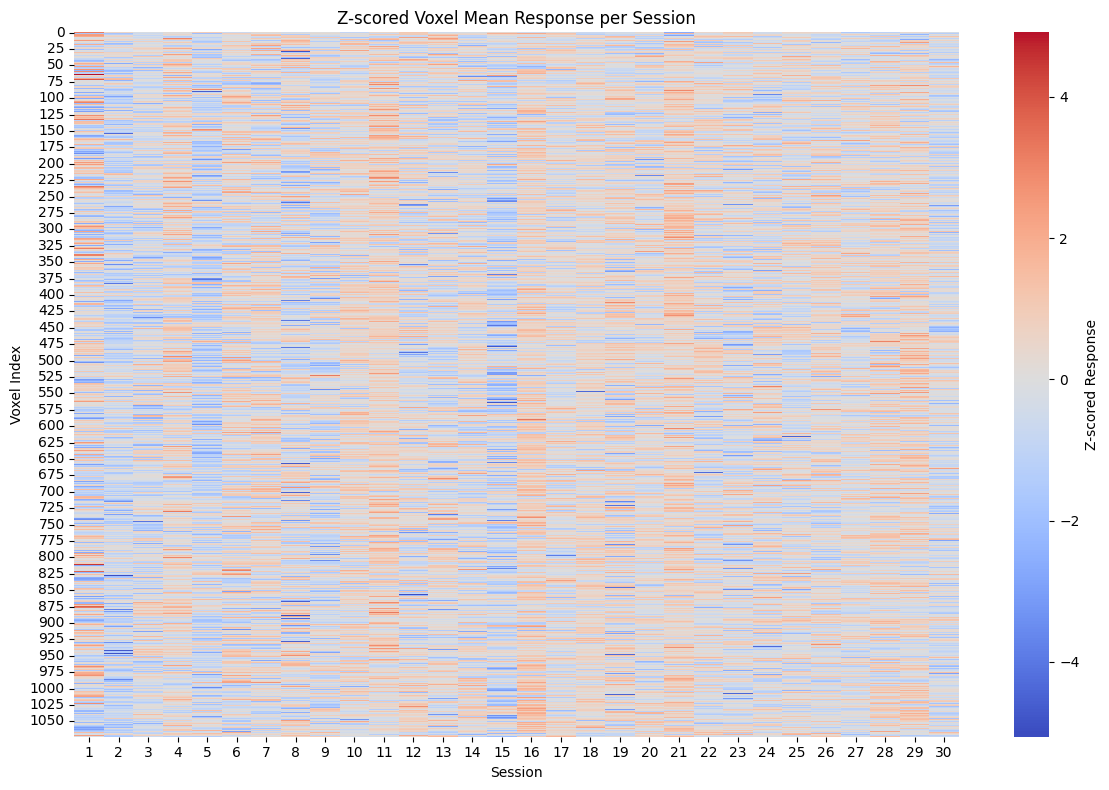

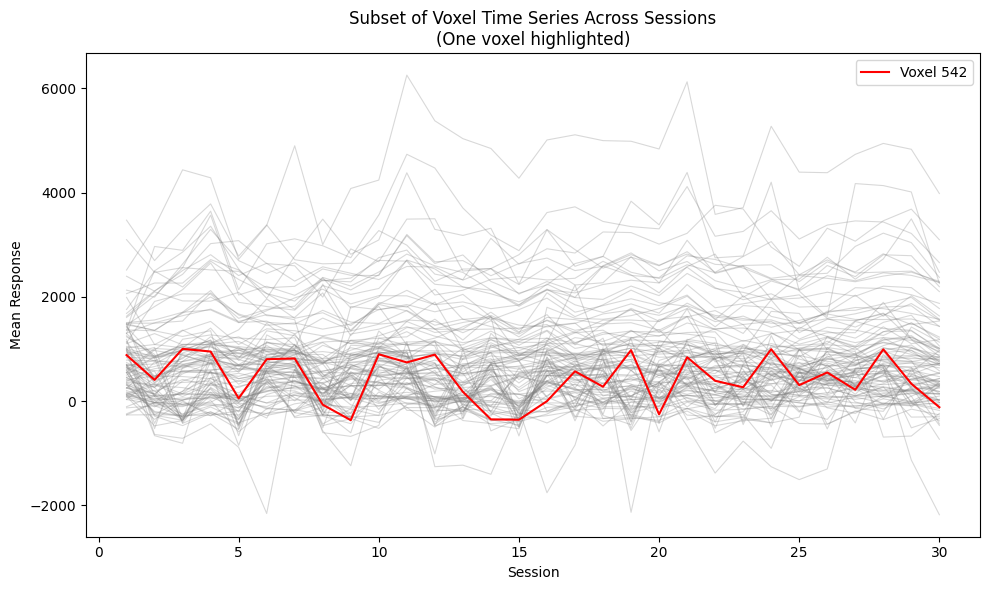

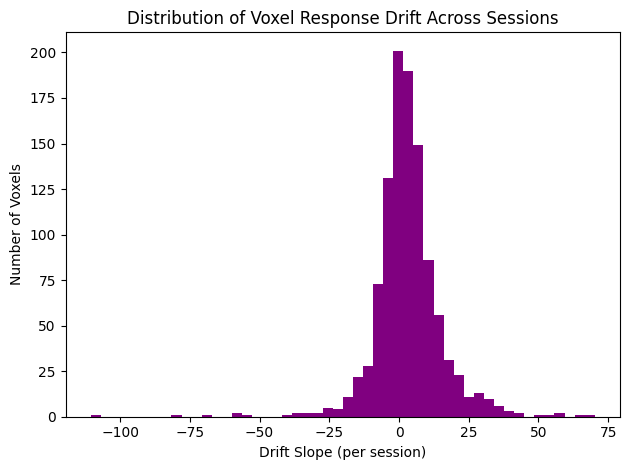

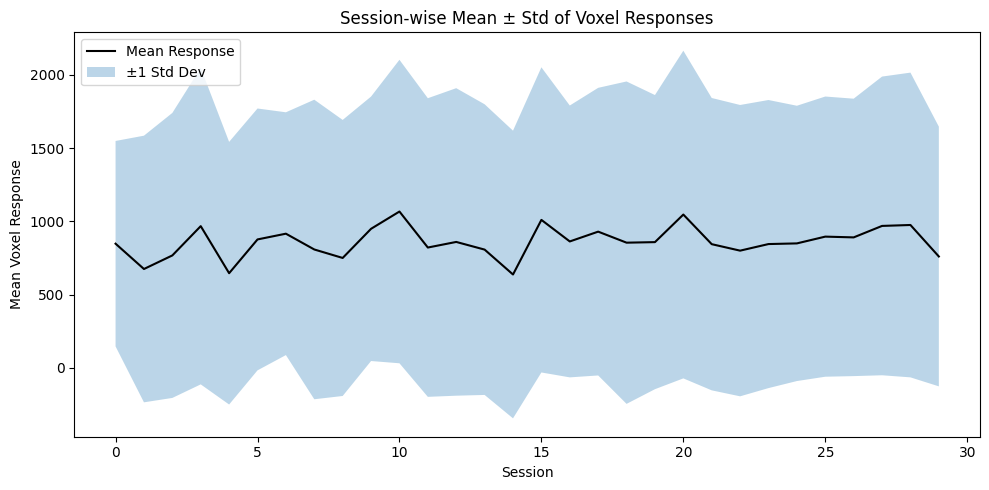

In [ ]:
import os
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Set subject ID (change this for each subject)
subject_id = "subj08"
# Set roi id
roi_group_label = "V1"  # Label for output file (like "V1", "V2", "hV4", etc)
selected_rois = ["V1v", "V1d"]  # Change this to ["V2v", "V2d", "hV4"] as needed
# Define paths
nsd_base_path = fr"D:\NSD\{subject_id}\betas"
# Central CSV directory for all subjects
csv_output_dir = r"D:\NSD\nsd_subjects_voxel_mean_responses"
os.makedirs(csv_output_dir, exist_ok=True)
# Define full path to ROI-specific CSV file
csv_path = os.path.join(csv_output_dir, f"{subject_id}_voxel_mean_response_matrix_{roi_group_label}.csv")
roi_path = fr"D:\NSD\{subject_id}\func1pt8mm\roi\prf-visualrois.nii.gz"

roi_label_map = {
    1: "V1v",
    2: "V1d",
    3: "V2v",
    4: "V2d",
    5: "V3v",
    6: "V3d",
    7: "hV4"
}

# Reverse the mapping for name → code
label_to_code = {v: k for k, v in roi_label_map.items()}
selected_roi_codes = [label_to_code[r] for r in selected_rois]

# --------------------------------------------
# Load or compute the voxel response matrix
# --------------------------------------------
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path, index_col=0)
    print("Loaded existing voxel mean response matrix from CSV.")
else:
    session_files = sorted([
        f for f in os.listdir(nsd_base_path)
        if f.startswith("betas_session") and f.endswith(".nii.gz")
    ])

    mean_responses = []
    session_names = []

    for filename in session_files:
        full_path = os.path.join(nsd_base_path, filename)
        print(f"Processing {filename}")
        img = nib.load(full_path)
        data = img.get_fdata()  # Shape: (x, y, z, time)

        if data.ndim == 4:
            mean_response = np.mean(data, axis=-1).flatten()
        else:
            raise ValueError(f"Unexpected data shape: {data.shape}")

        mean_responses.append(mean_response)
        session_names.append(filename.replace(".nii.gz", ""))

    # Stack into full matrix: voxels x sessions
    mean_response_matrix = np.stack(mean_responses, axis=1)

    #  V1 Filtering here 
    roi_img = nib.load(roi_path)
    roi_data = roi_img.get_fdata().flatten().astype(int)

    # Print ROI info (label + voxel count)
    unique_vals, counts = np.unique(roi_data, return_counts=True)
    roi_info = pd.DataFrame({"ROI Code": unique_vals, "Voxel Count": counts})
    roi_info["Label"] = roi_info["ROI Code"].map(roi_label_map)

    print("\nLabeled ROIs:")
    print(roi_info.dropna(subset=["Label"]))

    # Filter based on selected ROI codes
    v1_mask = np.isin(roi_data, selected_roi_codes)
    mean_response_matrix_v1 = mean_response_matrix[v1_mask]

    # Convert to DataFrame
    df = pd.DataFrame(mean_response_matrix_v1)
    df.columns = session_names
    df.index.name = "voxel_index"

    # Save ROI-filtered matrix
    df.to_csv(csv_path)
    roi_str = ", ".join(selected_rois)
    print(f"Saved: {csv_path} (ROIs: {roi_str})")


# --- Visualization Section ---

# Replace session names with simple session numbers: 1, 2, ..., 40
df.columns = range(1, df.shape[1] + 1)

# ---------------------------
# Raw Response Heatmap (Clipped)
# ---------------------------
vmin = np.percentile(df.values, 1)
vmax = np.percentile(df.values, 99)

plt.figure(figsize=(12, 8))
sns.heatmap(df, cmap="viridis", vmin=vmin, vmax=vmax, cbar_kws={"label": "Mean Response"})
plt.xlabel("Session")
plt.ylabel("Voxel Index")
plt.title("Voxel Mean Response per Session (Clipped Heatmap)")
plt.tight_layout()
plt.show()

# ---------------------------
# Z-scored Heatmap (per voxel)
# ---------------------------
# Manual z-scoring per voxel (row)
df_z = df.sub(df.mean(axis=1), axis=0).div(df.std(axis=1), axis=0)

# Drop any voxels with constant values (NaN after z-scoring)
df_z = df_z.dropna()

# Plot z-scored heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_z, cmap="coolwarm", center=0, cbar_kws={"label": "Z-scored Response"})
plt.xlabel("Session")
plt.ylabel("Voxel Index")
plt.title("Z-scored Voxel Mean Response per Session")
plt.tight_layout()
plt.show()


# Plot time series: each voxel across sessions
# Plot a random subset of voxel time series with a single legend entry
subset_df = df.sample(n=100, random_state=42)

# Get axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Plot all other voxels without any labels or legend
for idx in subset_df.index[1:]:
    ax.plot(subset_df.columns, subset_df.loc[idx], color='gray', alpha=0.3, linewidth=0.8)

# Plot the first voxel in red with legend
highlight_idx = subset_df.index[0]
ax.plot(subset_df.columns, subset_df.loc[highlight_idx], color='red', linewidth=1.5, label=f"Voxel {highlight_idx}")

# Finalize plot
ax.set_xlabel("Session")
ax.set_ylabel("Mean Response")
ax.set_title("Subset of Voxel Time Series Across Sessions\n(One voxel highlighted)")
ax.legend()
plt.tight_layout()
plt.show()


# drift slopes
slopes = []
for voxel_response in df.values:
    x = np.arange(df.shape[1]).reshape(-1, 1)  # sessions 0–39
    y = voxel_response
    model = LinearRegression().fit(x, y)
    slopes.append(model.coef_[0])  

# Histogram of voxel drifts
plt.hist(slopes, bins=50, color='purple')
plt.xlabel("Drift Slope (per session)")
plt.ylabel("Number of Voxels")
plt.title("Distribution of Voxel Response Drift Across Sessions")
plt.tight_layout()
plt.show()


# --- Summary Stats: Mean & Standard Deviation Across Voxels ---

# Compute session wise statistics (across voxels)
means = df.mean(axis=0)
stds = df.std(axis=0)

# Plot mean ± standard deviation across sessions
plt.figure(figsize=(10, 5))
plt.plot(means.values, label="Mean Response", color="black")
plt.fill_between(range(len(means)), means - stds, means + stds, alpha=0.3, label="±1 Std Dev")
plt.xlabel("Session")
plt.ylabel("Mean Voxel Response")
plt.title("Session-wise Mean ± Std of Voxel Responses")
plt.legend()
plt.tight_layout()
plt.show()

